In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [49]:
# === COLAB READY: Query planner + parquet retrieval + plots ===
# ------------- 1) Install dependencies (Colab) -------------
!pip install -q dask[complete] "pyarrow>=9.0.0" fastparquet matplotlib python-dateutil

# ------------- 2) Imports & config -------------
import os
import re
import json
import glob
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import dask.dataframe as dd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)

# --- CONFIG ---
PARQUET_DIR = "/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet"
METADATA_CSV = "/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_metadata_catalog.csv"
MAX_RETURN_ROWS = 1000

NAMED_REGIONS = {
    "bay of bengal": {"lat_min": 5, "lat_max": 22, "lon_min": 80, "lon_max": 95},
    "arabian sea": {"lat_min": 5, "lat_max": 25, "lon_min": 50, "lon_max": 75},
    "indian ocean": {"lat_min": -30, "lat_max": 30, "lon_min": 30, "lon_max": 110},
}

# ------------- 3) Metadata builder / loader -------------
def build_metadata_catalog(parquet_dir, out_csv=None, sample_rowgroups=1):
    files = sorted(glob.glob(os.path.join(parquet_dir, "*.parquet")))
    meta_rows = []
    if not files:
        raise FileNotFoundError(f"No parquet files found in {parquet_dir}")

    for f in files:
        try:
            pf = pq.ParquetFile(f)
            rg = pf.read_row_group(0).to_pandas() if pf.num_row_groups>0 else pf.read().to_pandas()

            def col_min_max(df, col):
                if col in df.columns and not df[col].isnull().all():
                    return float(df[col].min()), float(df[col].max())
                return np.nan, np.nan

            lat_min, lat_max = col_min_max(rg, "LATITUDE")
            lon_min, lon_max = col_min_max(rg, "LONGITUDE")
            depth_min, depth_max = col_min_max(rg, "DEPTH_M")

            jmin, jmax = np.nan, np.nan
            if "JULD" in rg.columns:
                try:
                    jseries = pd.to_datetime(rg["JULD"], errors="coerce")
                    if not jseries.isna().all():
                        jmin = jseries.min().isoformat()
                        jmax = jseries.max().isoformat()
                except Exception:
                    jmin, jmax = np.nan, np.nan

            meta_rows.append({
                "file_path": f,
                "file_name": os.path.basename(f),
                "lat_min_est": lat_min,
                "lat_max_est": lat_max,
                "lon_min_est": lon_min,
                "lon_max_est": lon_max,
                "depth_min_est": depth_min,
                "depth_max_est": depth_max,
                "juld_min_est": jmin,
                "juld_max_est": jmax,
                "num_row_groups": pf.num_row_groups,
                "num_rows": pf.metadata.num_rows
            })
        except Exception as e:
            print(f"  (metadata error on {f}: {e})")
    meta_df = pd.DataFrame(meta_rows)
    if out_csv:
        meta_df.to_csv(out_csv, index=False)
    return meta_df

if os.path.exists(METADATA_CSV):
    print("Loading existing metadata CSV:", METADATA_CSV)
    meta_df = pd.read_csv(METADATA_CSV)
else:
    print("Metadata CSV not found — building catalog...")
    meta_df = build_metadata_catalog(PARQUET_DIR, out_csv=METADATA_CSV)

print("Metadata rows:", len(meta_df))
display(meta_df.head())

# ------------- 4) Simple NL parser -> structured plan -------------
def parse_nl_query(text):
    txt = text.lower()
    plan = {"raw": text, "variables": [], "depth_filter": None, "region": None, "time": None}

    # variables
    if re.search(r"\btemp(erature)?\b", txt):
        plan["variables"].append("TEMP")
    if re.search(r"\bpsal\b|\bsalinity\b", txt):
        plan["variables"].append("PSAL")

    vs = re.findall(r"\b(temp|temperature|psal|salinity)\b", txt)
    for v in vs:
        if v.startswith("temp") and "TEMP" not in plan["variables"]:
            plan["variables"].append("TEMP")
        if v.startswith("psal") or v.startswith("salin"):
            if "PSAL" not in plan["variables"]:
                plan["variables"].append("PSAL")

    # depth
    m_single = re.search(r"(\d{1,4})\s*m\b", txt)
    m_range = re.search(r"(\d{1,4})\s*-\s*(\d{1,4})\s*m\b", txt)
    if m_range:
        d0, d1 = int(m_range.group(1)), int(m_range.group(2))
        plan["depth_filter"] = {"type":"range", "min_m":min(d0,d1), "max_m":max(d0,d1)}
    elif m_single:
        val = int(m_single.group(1))
        plan["depth_filter"] = {"type":"point", "m": val, "tol": 10}

    # region
    for name, bbox in NAMED_REGIONS.items():
        if name in txt:
            plan["region"] = {"name": name, "bbox": bbox}
            break
    m_bbox = re.search(r"lat(?:itude)?\s*([-\d\.]+)\s*[-to]+\s*([-\d\.]+).*lon(?:gitude)?\s*([-\d\.]+)\s*[-to]+\s*([-\d\.]+)", txt)
    if m_bbox:
        plan["region"] = {"name": "custom", "bbox":{
            "lat_min": float(m_bbox.group(1)), "lat_max": float(m_bbox.group(2)),
            "lon_min": float(m_bbox.group(3)), "lon_max": float(m_bbox.group(4))
        }}

    # time
    m_last = re.search(r"last\s+(\d+)\s+month", txt)
    if m_last:
        months = int(m_last.group(1))
        end = datetime.utcnow()
        start = end - relativedelta(months=months)
        plan["time"] = {"start": start.isoformat(), "end": end.isoformat()}
    m_year = re.search(r"\b(20\d{2})\b", txt)
    if m_year and plan["time"] is None:
        y = int(m_year.group(1))
        plan["time"] = {"start": datetime(y,1,1).isoformat(), "end": datetime(y,12,31,23,59,59).isoformat()}

    if plan["time"] is None:
        end = datetime.utcnow()
        start = end - relativedelta(months=6)
        plan["time"] = {"start": start.isoformat(), "end": end.isoformat()}

    if not plan["variables"]:
        plan["variables"] = ["TEMP", "PSAL"]

    return plan

# ------------- 5) Prune files by metadata -------------
def prune_files_by_metadata(plan, meta_df):
    candidates = meta_df.copy()
    if plan.get("region") and plan["region"].get("bbox"):
        b = plan["region"]["bbox"]
        cond = (
            (candidates["lat_max_est"].notna()) &
            (candidates["lat_min_est"].notna()) &
            (candidates["lon_max_est"].notna()) &
            (candidates["lon_min_est"].notna()) &
            (candidates["lat_max_est"] >= b["lat_min"]) &
            (candidates["lat_min_est"] <= b["lat_max"]) &
            (candidates["lon_max_est"] >= b["lon_min"]) &
            (candidates["lon_min_est"] <= b["lon_max"])
        )
        candidates = candidates.loc[cond]
    if plan.get("time"):
        start = pd.to_datetime(plan["time"]["start"])
        end = pd.to_datetime(plan["time"]["end"])
        mask_time = (
            (candidates["juld_max_est"].isna()) |
            (candidates["juld_min_est"].isna()) |
            (pd.to_datetime(candidates["juld_max_est"], errors='coerce') >= start) &
            (pd.to_datetime(candidates["juld_min_est"], errors='coerce') <= end)
        )
        candidates = candidates.loc[mask_time]
    return list(candidates["file_path"].unique())

# ------------- 6) Execute plan -------------
def execute_plan(plan, parquet_files, max_rows=MAX_RETURN_ROWS):
    if not parquet_files:
        return pd.DataFrame(), {"note":"no candidate files"}

    df = dd.read_parquet(parquet_files, engine="pyarrow")
    if "JULD" in df.columns:
        df["JULD"] = dd.to_datetime(df["JULD"], errors="coerce")

    if plan.get("region") and plan["region"].get("bbox"):
        b = plan["region"]["bbox"]
        df = df[(df["LATITUDE"] >= b["lat_min"]) & (df["LATITUDE"] <= b["lat_max"])]
        df = df[((df["LONGITUDE"] >= b["lon_min"]) & (df["LONGITUDE"] <= b["lon_max"])) |
                ((df["LONGITUDE"] % 360 >= b["lon_min"]) & (df["LONGITUDE"] % 360 <= b["lon_max"]))]

    if plan.get("time") and "JULD" in df.columns:
        start = pd.to_datetime(plan["time"]["start"])
        end = pd.to_datetime(plan["time"]["end"])
        df = df[(df["JULD"] >= start) & (df["JULD"] <= end)]

    if plan.get("depth_filter"):
        d = plan["depth_filter"]
        if d["type"] == "point":
            tol = d.get("tol", 10)
            df = df[df["DEPTH_M"].between(d["m"]-tol, d["m"]+tol)]
        else:
            df = df[df["DEPTH_M"].between(d["min_m"], d["max_m"])]

    var_cols = [v for v in plan["variables"] if v in df.columns]
    selected_cols = ["LATITUDE", "LONGITUDE", "JULD", "DEPTH_M"] + var_cols + ["source_file"]
    existing_cols = [c for c in selected_cols if c in df.columns]
    df = df[existing_cols]

    if "JULD" in df.columns:
        try:
            df = df.set_index("JULD").loc[plan["time"]["start"]:plan["time"]["end"]]
            res = df.head(max_rows, compute=True)
            res = res.reset_index()
        except Exception:
            res = df.head(max_rows, compute=True)
    else:
        res = df.head(max_rows, compute=True)

    return res, {"files_used": parquet_files, "n_rows": len(res)}

# ------------- 7) Auto visualization -------------
def auto_visualize(res_df, plan):
    if res_df.empty:
        print("No data to plot.")
        return

    primary_var = next((v for v in plan["variables"] if v in res_df.columns), None)
    if primary_var is None:
        print("No requested variable present in results.")
        return

    if "JULD" in res_df.columns and res_df["JULD"].nunique() > 1:
        if plan.get("depth_filter") and plan["depth_filter"]["type"] == "point":
            ts = res_df.groupby("JULD")[primary_var].mean().reset_index()
            plt.figure()
            plt.plot(ts["JULD"], ts[primary_var], marker='o', linestyle='-')
            plt.title(f"Timeseries: {primary_var} — {plan['raw']}")
            plt.xlabel("Time (JULD)")
            plt.ylabel(primary_var)
            plt.grid(True)
            plt.show()
            return

    if res_df["LATITUDE"].nunique() > 3 and res_df["LONGITUDE"].nunique() > 3:
        plt.figure()
        sc = plt.scatter(res_df["LONGITUDE"], res_df["LATITUDE"], c=res_df[primary_var], s=12, cmap='viridis')
        plt.colorbar(sc, label=primary_var)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Spatial scatter: {primary_var} — {plan['raw']}")
        plt.grid(False)
        plt.show()
        return

    if res_df["DEPTH_M"].nunique() > 3:
        prof = res_df.groupby("DEPTH_M")[primary_var].mean().reset_index().sort_values("DEPTH_M")
        plt.figure()
        plt.plot(prof[primary_var], prof["DEPTH_M"], marker='o')
        plt.gca().invert_yaxis()
        plt.xlabel(primary_var)
        plt.ylabel("Depth (m)")
        plt.title(f"Depth profile: {primary_var} — {plan['raw']}")
        plt.grid(True)
        plt.show()
        return

    plt.figure()
    plt.hist(res_df[primary_var].dropna(), bins=30)
    plt.title(f"Distribution: {primary_var}")
    plt.xlabel(primary_var)
    plt.ylabel("Count")
    plt.show()
# ------------- 8a) Helper: adjust query time to dataset -------------
def adjust_time_to_metadata(plan, meta_df):
    """
    Adjust the plan's time range so it intersects actual parquet files.
    If the user time window is outside the dataset, shrink it to dataset min/max.
    """
    # parse juld_min/max_est
    meta_df['juld_min_dt'] = pd.to_datetime(meta_df.get('juld_min_est', None), errors='coerce')
    meta_df['juld_max_dt'] = pd.to_datetime(meta_df.get('juld_max_est', None), errors='coerce')

    dataset_start = meta_df['juld_min_dt'].min()
    dataset_end = meta_df['juld_max_dt'].max()

    if pd.isna(dataset_start) or pd.isna(dataset_end):
        # fallback: use current time ± 2 years
        dataset_end = pd.Timestamp.utcnow().replace(tzinfo=None)
        dataset_start = dataset_end - pd.DateOffset(years=2)

    # Make both naive (remove timezone) to avoid TypeError
    if dataset_start.tzinfo is not None:
        dataset_start = dataset_start.tz_convert(None)
    if dataset_end.tzinfo is not None:
        dataset_end = dataset_end.tz_convert(None)

    user_start = pd.to_datetime(plan['time']['start']).replace(tzinfo=None)
    user_end   = pd.to_datetime(plan['time']['end']).replace(tzinfo=None)

    # clamp user range
    plan['time']['start'] = max(user_start, dataset_start).isoformat()
    plan['time']['end']   = min(user_end, dataset_end).isoformat()
    return plan



# ------------- 8) End-to-end NL query -------------
# ----------------- Full run_query() with safe loader -----------------

def run_query(nl_query):
    print("\n--- Parsing NL query ---")
    plan = parse_nl_query(nl_query)
    print("Plan (parsed):")
    print(json.dumps(plan, indent=2))

    # Adjust time according to metadata
    plan = adjust_time_to_metadata(plan, meta_df)
    print("\nAdjusted plan (clamped to dataset):")
    print(json.dumps(plan, indent=2))

    # Prune files
    print("\n--- Pruning files using metadata catalog ---")
    candidates = prune_files_by_metadata(plan, meta_df)
    print(f"Candidate parquet files (count={len(candidates)}):")
    for c in candidates[:10]:
        print("  ", os.path.basename(c))
    if not candidates:
        print("No candidate files found by metadata. Try a broader query.")
        return pd.DataFrame()  # Return empty df if no files

    # Load data and filter
    print("\n--- Executing plan (lazy load + filter) ---")
    res_df, info = execute_plan(plan, candidates, max_rows=MAX_RETURN_ROWS)
    print("Execution info:", info)
    if res_df.empty:
        print("No rows matched after filters.")
        return res_df

    # Show sample data
    print("\n--- Sample results (first rows) ---")
    display(res_df.head())

    # Auto visualization
    print("\n--- Auto visualization ---")
    auto_visualize(res_df, plan)

    # Return dataframe for further use
    return res_df




# ------------- 9) Ready example -------------
print("\nREADY. Example queries you can try:")
print("  run_query('Temperature at 500m in Bay of Bengal last 3 months')")
print("  run_query('Salinity and temperature at 100m in Arabian Sea 2023')")
print("  run_query('Temperature time series in Indian Ocean last 6 months')")

# Example execution
# run_query("Temperature at 500m in Bay of Bengal last 3 months")


Loading existing metadata CSV: /content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_metadata_catalog.csv
Metadata rows: 36


,file_path,year,month,lat_min,lat_max,lon_min,lon_max,depth_min,depth_max,num_rows
0,/content/drive/MyDrive/ColabNotebooks/SIH2025/...,2022,1,-39.869000,25.530760,30.86684,109.95030,0.0,4512.899902,1424143
1,/content/drive/MyDrive/ColabNotebooks/SIH2025/...,2022,2,-39.906908,25.096493,30.17752,109.77480,0.0,4510.209961,1279043
2,/content/drive/MyDrive/ColabNotebooks/SIH2025/...,2022,3,-39.985000,25.044137,31.17850,109.79900,-0.2,4512.849609,1396118
3,/content/drive/MyDrive/ColabNotebooks/SIH2025/...,2022,4,-39.929090,26.758967,30.53059,109.89499,-0.1,4502.609863,1465770
4,/content/drive/MyDrive/ColabNotebooks/SIH2025/...,2022,5,-39.912000,24.786320,31.01284,109.53160,0.0,4529.600098,1367667



READY. Example queries you can try:
  run_query('Temperature at 500m in Bay of Bengal last 3 months')
  run_query('Salinity and temperature at 100m in Arabian Sea 2023')
  run_query('Temperature time series in Indian Ocean last 6 months')



--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Temperature at 500m in Bay of Bengal 2023",
  "variables": [
    "TEMP"
  ],
  "depth_filter": {
    "type": "point",
    "m": 500,
    "tol": 10
  },
  "region": {
    "name": "bay of bengal",
    "bbox": {
      "lat_min": 5,
      "lat_max": 22,
      "lon_min": 80,
      "lon_max": 95
    }
  },
  "time": {
    "start": "2023-01-01T00:00:00",
    "end": "2023-12-31T23:59:59"
  }
}

Adjusted plan (clamped to dataset):
{
  "raw": "Temperature at 500m in Bay of Bengal 2023",
  "variables": [
    "TEMP"
  ],
  "depth_filter": {
    "type": "point",
    "m": 500,
    "tol": 10
  },
  "region": {
    "name": "bay of bengal",
    "bbox": {
      "lat_min": 5,
      "lat_max": 22,
      "lon_min": 80,
      "lon_max": 95
    }
  },
  "time": {
    "start": "2023-09-11T19:05:04.830128",
    "end": "2023-12-31T23:59:59"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (count=36):
   2022_01_MINIMAL.parquet
   202

/usr/local/lib/python3.12/dist-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 6 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,JULD,LATITUDE,LONGITUDE,DEPTH_M,TEMP,source_file
0,2023-09-14 21:13:00.000003584,11.995,84.704,493.399994,9.753,20230914_prof.nc
1,2023-09-14 21:13:00.000003584,11.995,84.704,502.600006,9.670,20230914_prof.nc
2,2023-09-14 21:13:00.000003584,11.995,84.704,503.600006,9.666,20230914_prof.nc
3,2023-09-19 17:01:00.000000000,11.940,84.965,493.399994,9.753,20230919_prof.nc
4,2023-09-19 17:01:00.000000000,11.940,84.965,502.299988,9.675,20230919_prof.nc



--- Auto visualization ---


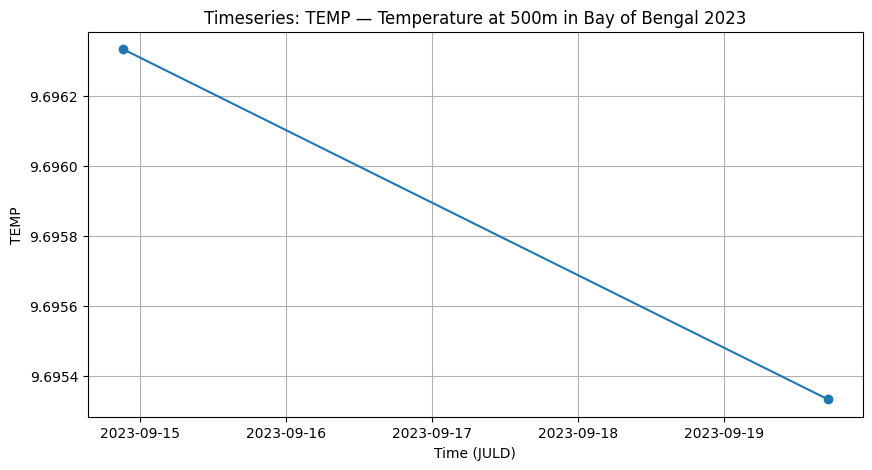

,JULD,LATITUDE,LONGITUDE,DEPTH_M,TEMP,source_file
0,2023-09-14 21:13:00.000003584,11.995,84.704,493.399994,9.753,20230914_prof.nc
1,2023-09-14 21:13:00.000003584,11.995,84.704,502.600006,9.670,20230914_prof.nc
2,2023-09-14 21:13:00.000003584,11.995,84.704,503.600006,9.666,20230914_prof.nc
3,2023-09-19 17:01:00.000000000,11.940,84.965,493.399994,9.753,20230919_prof.nc
4,2023-09-19 17:01:00.000000000,11.940,84.965,502.299988,9.675,20230919_prof.nc
5,2023-09-19 17:01:00.000000000,11.940,84.965,503.500000,9.658,20230919_prof.nc


from matplotlib import pyplot as plt
_df_0['LATITUDE'].plot(kind='hist', bins=20, title='LATITUDE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['LONGITUDE'].plot(kind='hist', bins=20, title='LONGITUDE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['DEPTH_M'].plot(kind='hist', bins=20, title='DEPTH_M')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['TEMP'].plot(kind='hist', bins=20, title='TEMP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='LATITUDE', y='LONGITUDE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='LONGITUDE', y='DEPTH_M', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='DEPTH_M', y='TEMP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['JULD']
  ys = series['LATITUDE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('JULD', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('JULD')
_ = plt.ylabel('LATITUDE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['JULD']
  ys = series['DEPTH_M']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('JULD', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('JULD')
_ = plt.ylabel('DEPTH_M')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['JULD']
  ys = series['TEMP']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('JULD', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('JULD')
_ = plt.ylabel('TEMP')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['JULD']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'JULD'}, axis=1)
              .sort_values('JULD', ascending=True))
  xs = counted['JULD']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('JULD', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('JULD')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['LATITUDE'].plot(kind='line', figsize=(8, 4), title='LATITUDE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['LONGITUDE'].plot(kind='line', figsize=(8, 4), title='LONGITUDE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['DEPTH_M'].plot(kind='line', figsize=(8, 4), title='DEPTH_M')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['TEMP'].plot(kind='line', figsize=(8, 4), title='TEMP')
plt.gca().spines[['top', 'right']].set_visible(False)

In [43]:
run_query("Temperature at 500m in Bay of Bengal 2023")



--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Temperature time series in Indian Ocean last 2024",
  "variables": [
    "TEMP"
  ],
  "depth_filter": null,
  "region": {
    "name": "indian ocean",
    "bbox": {
      "lat_min": -30,
      "lat_max": 30,
      "lon_min": 30,
      "lon_max": 110
    }
  },
  "time": {
    "start": "2024-01-01T00:00:00",
    "end": "2024-12-31T23:59:59"
  }
}

Adjusted plan (clamped to dataset):
{
  "raw": "Temperature time series in Indian Ocean last 2024",
  "variables": [
    "TEMP"
  ],
  "depth_filter": null,
  "region": {
    "name": "indian ocean",
    "bbox": {
      "lat_min": -30,
      "lat_max": 30,
      "lon_min": 30,
      "lon_max": 110
    }
  },
  "time": {
    "start": "2024-01-01T00:00:00",
    "end": "2024-12-31T23:59:59"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (count=36):
   2022_01_MINIMAL.parquet
   2022_02_MINIMAL.parquet
   2022_03_MINIMAL.parquet
   2022_04_MINIMAL.parquet
   2022_05_M

,JULD,LATITUDE,LONGITUDE,DEPTH_M,TEMP,source_file
0,2024-01-01 00:50:30,15.861177,62.079912,NaN,NaN,20240101_prof.nc
1,2024-01-01 00:50:30,15.861177,62.079912,537.700012,12.276,20240101_prof.nc
2,2024-01-01 00:50:30,15.861177,62.079912,539.400024,12.256,20240101_prof.nc
3,2024-01-01 00:50:30,15.861177,62.079912,541.099976,12.250,20240101_prof.nc
4,2024-01-01 00:50:30,15.861177,62.079912,543.299988,12.247,20240101_prof.nc



--- Auto visualization ---


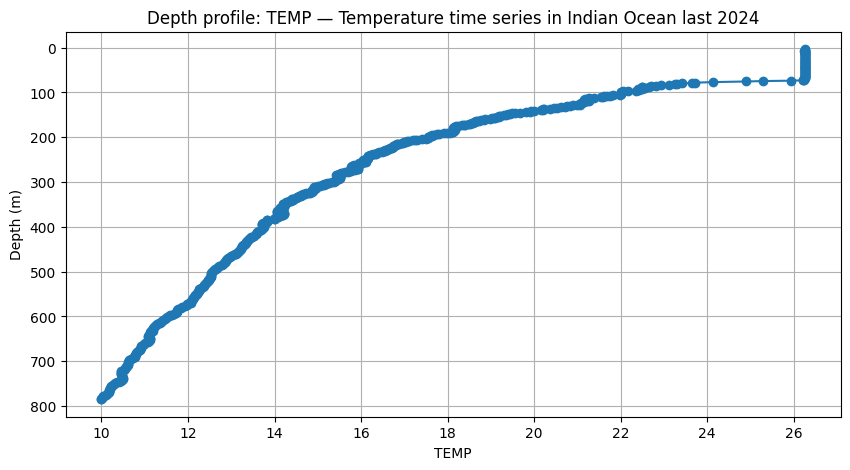

In [36]:
run_query('Temperature time series in Indian Ocean last 2024')


--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Salinity and temperature at 100m in Arabian Sea 2023",
  "variables": [
    "TEMP",
    "PSAL"
  ],
  "depth_filter": {
    "type": "point",
    "m": 100,
    "tol": 10
  },
  "region": {
    "name": "arabian sea",
    "bbox": {
      "lat_min": 5,
      "lat_max": 25,
      "lon_min": 50,
      "lon_max": 75
    }
  },
  "time": {
    "start": "2023-01-01T00:00:00",
    "end": "2023-12-31T23:59:59"
  }
}

Adjusted plan (clamped to dataset):
{
  "raw": "Salinity and temperature at 100m in Arabian Sea 2023",
  "variables": [
    "TEMP",
    "PSAL"
  ],
  "depth_filter": {
    "type": "point",
    "m": 100,
    "tol": 10
  },
  "region": {
    "name": "arabian sea",
    "bbox": {
      "lat_min": 5,
      "lat_max": 25,
      "lon_min": 50,
      "lon_max": 75
    }
  },
  "time": {
    "start": "2023-09-11T18:58:36.257755",
    "end": "2023-12-31T23:59:59"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (co

/usr/local/lib/python3.12/dist-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 101 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,JULD,LATITUDE,LONGITUDE,DEPTH_M,TEMP,PSAL,source_file
0,2023-09-12 03:32:01.000368128,14.1175,69.7919,90.229996,24.294001,36.049000,20230912_prof.nc
1,2023-09-12 03:32:01.000368128,14.1175,69.7919,92.229996,23.916000,35.988998,20230912_prof.nc
2,2023-09-12 03:32:01.000368128,14.1175,69.7919,93.930000,23.547001,35.949001,20230912_prof.nc
3,2023-09-12 03:32:01.000368128,14.1175,69.7919,96.029999,23.221001,35.914001,20230912_prof.nc
4,2023-09-12 03:32:01.000368128,14.1175,69.7919,98.129997,22.787001,35.868999,20230912_prof.nc



--- Auto visualization ---


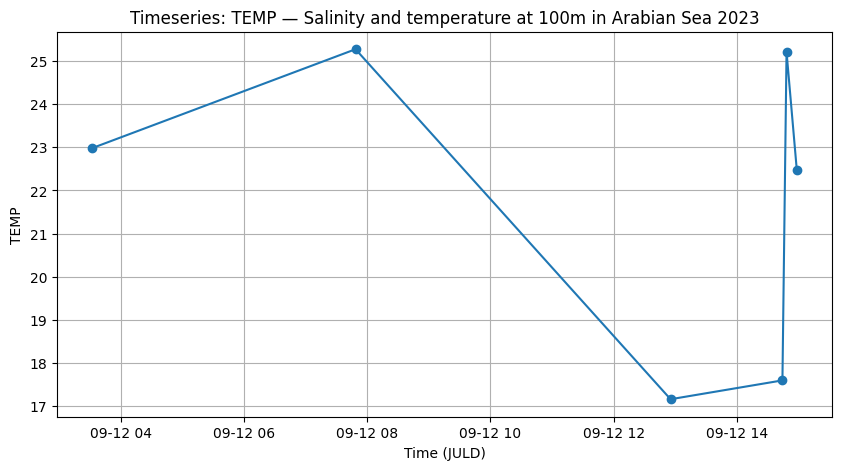

In [37]:
run_query('Salinity and temperature at 100m in Arabian Sea 2023')

In [52]:
meta_df = pd.read_csv(METADATA_CSV)

# Rename existing columns
meta_df = meta_df.rename(columns={
    "lat_min": "lat_min_est",
    "lat_max": "lat_max_est",
    "lon_min": "lon_min_est",
    "lon_max": "lon_max_est",
    "depth_min": "depth_min_est",
    "depth_max": "depth_max_est"
})

# Add missing columns for JULD estimates (set NaN)
if "juld_min_est" not in meta_df.columns:
    meta_df["juld_min_est"] = np.nan
if "juld_max_est" not in meta_df.columns:
    meta_df["juld_max_est"] = np.nan

print(meta_df.columns)


Index(['file_path', 'year', 'month', 'lat_min_est', 'lat_max_est',
       'lon_min_est', 'lon_max_est', 'depth_min_est', 'depth_max_est',
       'num_rows', 'juld_min_est', 'juld_max_est'],
      dtype='object')



--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Temperature at 500m in Bay of Bengal 2024",
  "variables": [
    "TEMP"
  ],
  "depth_filter": {
    "type": "point",
    "m": 500,
    "tol": 10
  },
  "region": {
    "name": "bay of bengal",
    "bbox": {
      "lat_min": 5,
      "lat_max": 22,
      "lon_min": 80,
      "lon_max": 95
    }
  },
  "time": {
    "start": "2024-01-01T00:00:00",
    "end": "2024-12-31T23:59:59"
  }
}

Adjusted plan (clamped to dataset):
{
  "raw": "Temperature at 500m in Bay of Bengal 2024",
  "variables": [
    "TEMP"
  ],
  "depth_filter": {
    "type": "point",
    "m": 500,
    "tol": 10
  },
  "region": {
    "name": "bay of bengal",
    "bbox": {
      "lat_min": 5,
      "lat_max": 22,
      "lon_min": 80,
      "lon_max": 95
    }
  },
  "time": {
    "start": "2024-01-01T00:00:00",
    "end": "2024-12-31T23:59:59"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (count=36):
   2022_01_MINIMAL.parquet
   2022_02_MI

/usr/local/lib/python3.12/dist-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 10 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,JULD,LATITUDE,LONGITUDE,DEPTH_M,TEMP,source_file
0,2024-01-06 06:14:56.000664064,9.82378,85.17153,490.040009,9.876,20240106_prof.nc
1,2024-01-06 06:14:56.000664064,9.82378,85.17153,492.040009,9.861,20240106_prof.nc
2,2024-01-06 06:14:56.000664064,9.82378,85.17153,494.040009,9.843,20240106_prof.nc
3,2024-01-06 06:14:56.000664064,9.82378,85.17153,496.079987,9.833,20240106_prof.nc
4,2024-01-06 06:14:56.000664064,9.82378,85.17153,498.000000,9.824,20240106_prof.nc



--- Auto visualization ---


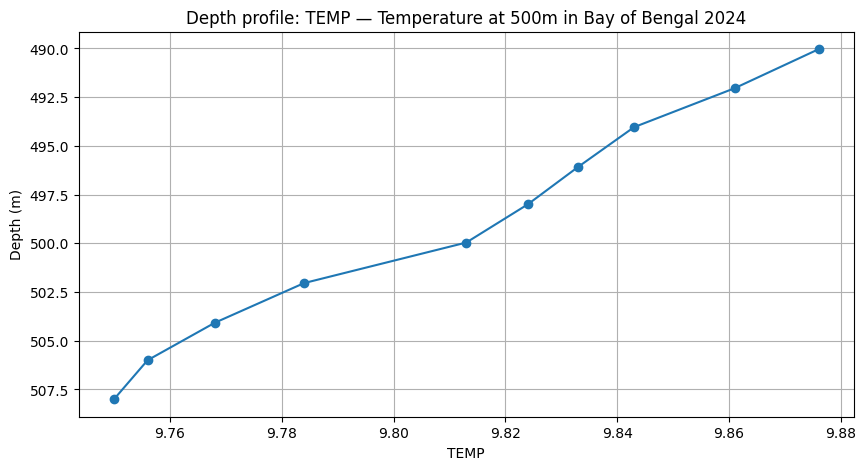

In [59]:
res_df = run_query("Temperature at 500m in Bay of Bengal 2024")


In [55]:
res_df.head()


,JULD,LATITUDE,LONGITUDE,DEPTH_M,TEMP,source_file
0,2024-01-06 06:14:56.000664064,9.82378,85.17153,490.040009,9.876,20240106_prof.nc
1,2024-01-06 06:14:56.000664064,9.82378,85.17153,492.040009,9.861,20240106_prof.nc
2,2024-01-06 06:14:56.000664064,9.82378,85.17153,494.040009,9.843,20240106_prof.nc
3,2024-01-06 06:14:56.000664064,9.82378,85.17153,496.079987,9.833,20240106_prof.nc
4,2024-01-06 06:14:56.000664064,9.82378,85.17153,498.000000,9.824,20240106_prof.nc


In [56]:
# First few rows
res_df.head()

# Basic statistics
res_df['TEMP'].describe()

# Check unique depths, latitudes, longitudes
print("Depths:", res_df['DEPTH_M'].unique())
print("Latitude range:", res_df['LATITUDE'].min(), res_df['LATITUDE'].max())
print("Longitude range:", res_df['LONGITUDE'].min(), res_df['LONGITUDE'].max())


Depths: [490.04 492.04 494.04 496.08 498.   499.96 502.04 504.08 506.   508.  ]
Latitude range: 9.82378 9.82378
Longitude range: 85.17153 85.17153


In [58]:
res_df.to_csv("/content/drive/MyDrive/ColabNotebooks/SIH2025/Results/bay_of_bengal_temp_500m.csv", index=False)
res_df.to_parquet("/content/drive/MyDrive/ColabNotebooks/SIH2025/Results/bay_of_bengal_temp_500m.parquet", index=False)


In [61]:
# ------------- 10) Update run_query() to auto-save -------------
RESULTS_DIR = "/content/drive/MyDrive/ColabNotebooks/SIH2025/Results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def run_query(nl_query, save_result=True):
    print("\n--- Parsing NL query ---")
    plan = parse_nl_query(nl_query)
    print("Plan (parsed):")
    print(json.dumps(plan, indent=2))

    # --- Adjust time according to dataset metadata ---
    plan = adjust_time_to_metadata(plan, meta_df)
    print("\nAdjusted plan (clamped to dataset):")
    print(json.dumps(plan, indent=2))

    # --- Prune files using metadata catalog ---
    print("\n--- Pruning files using metadata catalog ---")
    candidates = prune_files_by_metadata(plan, meta_df)
    print(f"Candidate parquet files (count={len(candidates)}):")
    for c in candidates[:10]:
        print("  ", os.path.basename(c))
    if not candidates:
        print("No candidate files found by metadata. Try a broader query.")
        return

    # --- Load data and filter ---
    print("\n--- Executing plan (lazy load + filter) ---")
    res_df, info = execute_plan(plan, candidates, max_rows=MAX_RETURN_ROWS)
    print("Execution info:", info)
    if res_df.empty:
        print("No rows matched after filters.")
        return

    # --- Show sample data ---
    print("\n--- Sample results (first rows) ---")
    display(res_df.head())

    # --- Auto visualization ---
    print("\n--- Auto visualization ---")
    auto_visualize(res_df, plan)

    # --- Save result if requested ---
    if save_result:
        # Create a descriptive filename
        vars_part = "_".join(plan["variables"])
        region_part = plan["region"]["name"].replace(" ", "_") if plan.get("region") else "all_regions"
        depth_part = f"{plan['depth_filter']['m']}m" if plan.get("depth_filter") and plan["depth_filter"]["type"]=="point" else ""
        start_date = plan["time"]["start"][:10]
        end_date = plan["time"]["end"][:10]
        filename = f"{vars_part}_{region_part}_{depth_part}_{start_date}_to_{end_date}.csv"
        filepath = os.path.join(RESULTS_DIR, filename)

        res_df.to_csv(filepath, index=False)
        print(f"\n✅ Result saved to: {filepath}")

    return res_df



--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Temperature at 500m in Bay of Bengal 2023",
  "variables": [
    "TEMP"
  ],
  "depth_filter": {
    "type": "point",
    "m": 500,
    "tol": 10
  },
  "region": {
    "name": "bay of bengal",
    "bbox": {
      "lat_min": 5,
      "lat_max": 22,
      "lon_min": 80,
      "lon_max": 95
    }
  },
  "time": {
    "start": "2023-01-01T00:00:00",
    "end": "2023-12-31T23:59:59"
  }
}

Adjusted plan (clamped to dataset):
{
  "raw": "Temperature at 500m in Bay of Bengal 2023",
  "variables": [
    "TEMP"
  ],
  "depth_filter": {
    "type": "point",
    "m": 500,
    "tol": 10
  },
  "region": {
    "name": "bay of bengal",
    "bbox": {
      "lat_min": 5,
      "lat_max": 22,
      "lon_min": 80,
      "lon_max": 95
    }
  },
  "time": {
    "start": "2023-09-11T19:22:14.344929",
    "end": "2023-12-31T23:59:59"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (count=36):
   2022_01_MINIMAL.parquet
   202

/usr/local/lib/python3.12/dist-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 3 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,JULD,LATITUDE,LONGITUDE,DEPTH_M,TEMP,source_file
0,2023-09-14 21:13:00.000003584,11.995,84.704,493.399994,9.753,20230914_prof.nc
1,2023-09-14 21:13:00.000003584,11.995,84.704,502.600006,9.670,20230914_prof.nc
2,2023-09-14 21:13:00.000003584,11.995,84.704,503.600006,9.666,20230914_prof.nc



--- Auto visualization ---


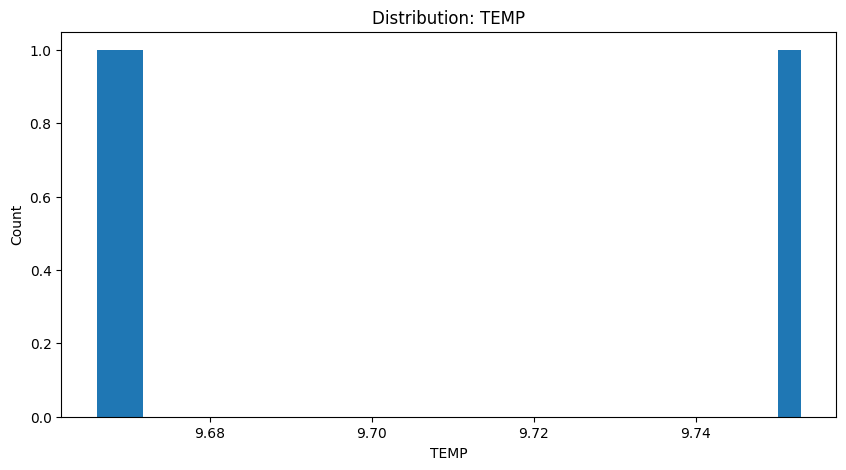


--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Salinity at 100m in Arabian Sea 2023",
  "variables": [
    "PSAL"
  ],
  "depth_filter": {
    "type": "point",
    "m": 100,
    "tol": 10
  },
  "region": {
    "name": "arabian sea",
    "bbox": {
      "lat_min": 5,
      "lat_max": 25,
      "lon_min": 50,
      "lon_max": 75
    }
  },
  "time": {
    "start": "2023-01-01T00:00:00",
    "end": "2023-12-31T23:59:59"
  }
}

Adjusted plan (clamped to dataset):
{
  "raw": "Salinity at 100m in Arabian Sea 2023",
  "variables": [
    "PSAL"
  ],
  "depth_filter": {
    "type": "point",
    "m": 100,
    "tol": 10
  },
  "region": {
    "name": "arabian sea",
    "bbox": {
      "lat_min": 5,
      "lat_max": 25,
      "lon_min": 50,
      "lon_max": 75
    }
  },
  "time": {
    "start": "2023-09-11T19:22:34.416351",
    "end": "2023-12-31T23:59:59"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (count=36):
   2022_01_MINIMAL.parquet
   2022_02_MINIMAL.p

/usr/local/lib/python3.12/dist-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 101 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,JULD,LATITUDE,LONGITUDE,DEPTH_M,PSAL,source_file
0,2023-09-12 03:32:01.000368128,14.1175,69.7919,90.229996,36.049000,20230912_prof.nc
1,2023-09-12 03:32:01.000368128,14.1175,69.7919,92.229996,35.988998,20230912_prof.nc
2,2023-09-12 03:32:01.000368128,14.1175,69.7919,93.930000,35.949001,20230912_prof.nc
3,2023-09-12 03:32:01.000368128,14.1175,69.7919,96.029999,35.914001,20230912_prof.nc
4,2023-09-12 03:32:01.000368128,14.1175,69.7919,98.129997,35.868999,20230912_prof.nc



--- Auto visualization ---


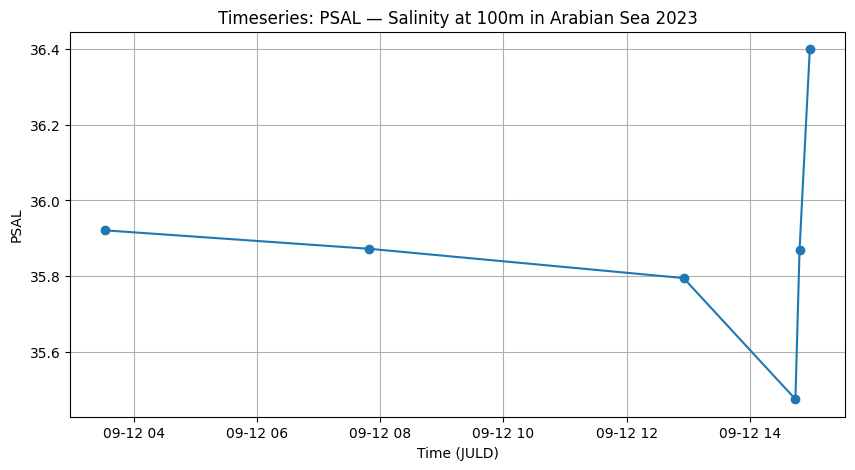


--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Temperature time series in Indian Ocean 2023",
  "variables": [
    "TEMP"
  ],
  "depth_filter": null,
  "region": {
    "name": "indian ocean",
    "bbox": {
      "lat_min": -30,
      "lat_max": 30,
      "lon_min": 30,
      "lon_max": 110
    }
  },
  "time": {
    "start": "2023-01-01T00:00:00",
    "end": "2023-12-31T23:59:59"
  }
}

Adjusted plan (clamped to dataset):
{
  "raw": "Temperature time series in Indian Ocean 2023",
  "variables": [
    "TEMP"
  ],
  "depth_filter": null,
  "region": {
    "name": "indian ocean",
    "bbox": {
      "lat_min": -30,
      "lat_max": 30,
      "lon_min": 30,
      "lon_max": 110
    }
  },
  "time": {
    "start": "2023-09-11T19:22:55.667373",
    "end": "2023-12-31T23:59:59"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (count=36):
   2022_01_MINIMAL.parquet
   2022_02_MINIMAL.parquet
   2022_03_MINIMAL.parquet
   2022_04_MINIMAL.parquet
   2022_05_MINI

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2324631692.py", line 8, in <cell line: 0>
    res_df=run_query(q)
           ^^^^^^^^^^^^
  File "/tmp/ipython-input-3689888850.py", line 343, in run_query
    res_df, info = execute_plan(plan, candidates, max_rows=MAX_RETURN_ROWS)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3689888850.py", line 222, in execute_plan
    res = df.head(max_rows, compute=True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_collection.py", line 692, in head
    out = out.compute()
          ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/dask/base.py", line 373, in compute
    (result,) = compute(self, traverse=False, **kwargs)
                ^^^^^

TypeError: object of type 'NoneType' has no len()

In [60]:
queries = [
    "Temperature at 500m in Bay of Bengal 2023",
    "Salinity at 100m in Arabian Sea 2023",
    "Temperature time series in Indian Ocean 2023"
]

for q in queries:
    res_df=run_query(q)



--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Temperature at 500m in Bay of Bengal 2023",
  "variables": [
    "TEMP"
  ],
  "depth_filter": {
    "type": "point",
    "m": 500,
    "tol": 10
  },
  "region": {
    "name": "bay of bengal",
    "bbox": {
      "lat_min": 5,
      "lat_max": 22,
      "lon_min": 80,
      "lon_max": 95
    }
  },
  "time": {
    "start": "2023-01-01T00:00:00",
    "end": "2023-12-31T23:59:59"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (count=36):
   2022_01_MINIMAL.parquet
   2022_02_MINIMAL.parquet
   2022_03_MINIMAL.parquet
   2022_04_MINIMAL.parquet
   2022_05_MINIMAL.parquet
   2022_06_MINIMAL.parquet
   2022_07_MINIMAL.parquet
   2022_08_MINIMAL.parquet
   2022_09_MINIMAL.parquet
   2022_10_MINIMAL.parquet

--- Executing plan (lazy load + filter) ---
Execution info: {'files_used': ['/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_01_MINIMAL.parquet', '/content/drive/MyDrive/Colab

/usr/local/lib/python3.12/dist-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 5 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,JULD,LATITUDE,LONGITUDE,DEPTH_M,TEMP,source_file
0,2023-01-01 15:53:59.999997952,11.004,85.762,493.600006,10.167,20230101_prof.nc
1,2023-01-01 15:53:59.999997952,11.004,85.762,502.100006,10.110,20230101_prof.nc
2,2023-01-01 15:53:59.999997952,11.004,85.762,503.299988,10.103,20230101_prof.nc
3,2023-01-04 01:57:00.000004096,19.114,88.653,490.799988,10.131,20230104_prof.nc
4,2023-01-04 01:57:00.000004096,19.114,88.653,501.500000,10.051,20230104_prof.nc



--- Auto visualization ---


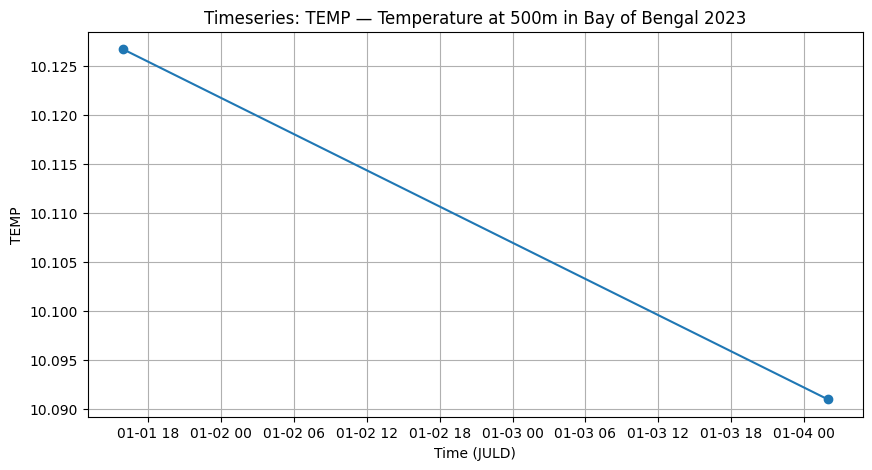

In [10]:
run_query("Temperature at 500m in Bay of Bengal 2023")


In [14]:
run_query("Temperature at 500m in Bay of Bengal last 3 months")



--- Parsing NL query ---
Plan (parsed):
{
  "raw": "Temperature at 500m in Bay of Bengal last 3 months",
  "variables": [
    "TEMP"
  ],
  "depth_filter": {
    "type": "point",
    "m": 500,
    "tol": 10
  },
  "region": {
    "name": "bay of bengal",
    "bbox": {
      "lat_min": 5,
      "lat_max": 22,
      "lon_min": 80,
      "lon_max": 95
    }
  },
  "time": {
    "start": "2025-06-11T18:34:34.575092",
    "end": "2025-09-11T18:34:34.575092"
  }
}

--- Pruning files using metadata catalog ---
Candidate parquet files (count=36):
   2022_01_MINIMAL.parquet
   2022_02_MINIMAL.parquet
   2022_03_MINIMAL.parquet
   2022_04_MINIMAL.parquet
   2022_05_MINIMAL.parquet
   2022_06_MINIMAL.parquet
   2022_07_MINIMAL.parquet
   2022_08_MINIMAL.parquet
   2022_09_MINIMAL.parquet
   2022_10_MINIMAL.parquet

--- Executing plan (lazy load + filter) ---


/tmp/ipython-input-1933644893.py:140: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow()


Execution info: {'files_used': ['/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_01_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_02_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_03_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_04_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_05_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_06_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_07_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_08_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/2022_09_MINIMAL.parquet', '/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_pr

In [15]:
meta_df[['year','month']].drop_duplicates().sort_values(['year','month'])


,year,month
0,2022,1
1,2022,2
2,2022,3
3,2022,4
4,2022,5
5,2022,6
6,2022,7
7,2022,8
8,2022,9
9,2022,10


In [18]:
# --- Step 0: Safe query & time/region/depth check ---
import pandas as pd
from datetime import datetime

# Example query
query = {
    "variable": "TEMP",
    "depth": 500,  # meters
    "depth_tol": 10,
    "lat_min": 5,
    "lat_max": 22,
    "lon_min": 80,
    "lon_max": 95,
    "start": datetime(2025, 6, 11),
    "end": datetime(2025, 9, 11)
}

# --- Step 1: Check available time ---
available_years_months = meta_df[['year', 'month']].drop_duplicates().sort_values(['year','month'])
print("Available year/month in metadata:\n", available_years_months)

# Adjust time if requested range is outside metadata
min_year, max_year = available_years_months['year'].min(), available_years_months['year'].max()
if query['start'].year < min_year or query['end'].year > max_year:
    print(f"⚠️ Requested time {query['start']} → {query['end']} is outside available data range. Adjusting to available range.")
    query['start'] = datetime(min_year, 1, 1)
    query['end'] = datetime(max_year, 12, 31)

# --- Step 2: Filter by region and depth ---
region_filtered = meta_df[
    (meta_df['lat_max'] >= query['lat_min']) &
    (meta_df['lat_min'] <= query['lat_max']) &
    (meta_df['lon_max'] >= query['lon_min']) &
    (meta_df['lon_min'] <= query['lon_max'])
]

if region_filtered.empty:
    print("⚠️ No files cover the requested region. Please expand the lat/lon bounds.")
else:
    # Check depth coverage
    depth_filtered = region_filtered[
        (region_filtered['depth_max'] >= query['depth'] - query['depth_tol']) &
        (region_filtered['depth_min'] <= query['depth'] + query['depth_tol'])
    ]

    if depth_filtered.empty:
        print("⚠️ No files cover the requested depth. Consider increasing depth tolerance or changing depth.")
        print("Available depth ranges in region:")
        print(region_filtered[['depth_min','depth_max']])
    else:
        print(f"✅ Found {len(depth_filtered)} files matching region and depth filters:")
        print(depth_filtered[['file_path','year','month','depth_min','depth_max']])

        # --- Step 3: Load the actual data from these files ---
        data_list = []
        for file_path in depth_filtered['file_path']:
            df = pd.read_parquet(file_path)
            # Filter depth within ± tolerance
            df_depth = df[(df['DEPTH_M'] >= query['depth'] - query['depth_tol']) &
                          (df['DEPTH_M'] <= query['depth'] + query['depth_tol'])]
            # Filter lat/lon
            df_depth_region = df_depth[
                (df_depth['LATITUDE'] >= query['lat_min']) &
                (df_depth['LATITUDE'] <= query['lat_max']) &
                (df_depth['LONGITUDE'] >= query['lon_min']) &
                (df_depth['LONGITUDE'] <= query['lon_max'])
            ]
            data_list.append(df_depth_region)

        if data_list:
            final_data = pd.concat(data_list, ignore_index=True)
            print(f"✅ Total rows after all filters: {len(final_data)}")
        else:
            print("⚠️ No data matched after applying all filters.")


Available year/month in metadata:
     year  month
0   2022      1
1   2022      2
2   2022      3
3   2022      4
4   2022      5
5   2022      6
6   2022      7
7   2022      8
8   2022      9
9   2022     10
10  2022     11
11  2022     12
12  2023      1
13  2023      2
14  2023      3
15  2023      4
16  2023      5
17  2023      6
18  2023      7
19  2023      8
20  2023      9
21  2023     10
22  2023     11
23  2023     12
24  2024      1
25  2024      2
26  2024      3
27  2024      4
28  2024      5
29  2024      6
30  2024      7
31  2024      8
32  2024      9
33  2024     10
34  2024     11
35  2024     12
⚠️ Requested time 2025-06-11 00:00:00 → 2025-09-11 00:00:00 is outside available data range. Adjusting to available range.
✅ Found 36 files matching region and depth filters:
                                            file_path  year  month  \
0   /content/drive/MyDrive/ColabNotebooks/SIH2025/...  2022      1   
1   /content/drive/MyDrive/ColabNotebooks/SIH2025/...  202